# Bayesian Optimization.

A critical task in most machine learning or probabilistic programming pipelines is the optimization of model hyperparameters. Several strategies can be used for function optimization, such as randomly sampling the parameter space (**random search**) or systematically evaluating the parameter space (**grid search**). This is often not trivial, because the loss function for a particular parameter can be noisy and non-linear, and for most problems we are omptimizing a set of parameters simultaneously, which can result in a high-dimensional, non-convex problem that is difficult to evaluate. Moreover, for large problems and complex models (e.g. deep neural networks) a single model run can be expensive and time-consuming. As a result, doing systematic searches over the hyperparameter space is infeasible, and random searches are usually ineffective.

To circumvent this, Bayesian optimization offers a principled and efficient approach for directing a search of arbitrary global optimization problems. It involves constructing a probabilistic model of the objective function, and then using an auxiliary function, called an **acquisition function**, to obtain candidate values for evaluation using the true objective function.

Bayesian Optimization is often used in applied machine learning to tune the hyperparameters of a given model on a validation dataset.

## Optimization

Global function optimization involves finding the minimum (maximum) of a function of interest. **Samples** are drawn from the domain and evaluated by the **objective function** to give a score or **cost**. These samples are candidate optimal values, which are compared to previous samples based on their cost. While the objective function may be simple to specify mathematically and in code, it can be computationally challenging to compute, and its form may be non-linear and multi-dimensional. Moreover, its solution may be non-convex, implying that a discovered mimimum value may not be a global minimum. 

Specific to data science, many machine learning algorithms involve the optimization of weights, coefficients, and hyperparameters based on information contained in training data. We seek a principled method for evaluating the parmaeter space, such that consecutive samples are taken from regions of the search space that are more likely to contain minima.

One such approach to global optimization is **Bayesian Optimization**. As the name implies, this approach uses Bayes Theorem to direct the parameter search, and is well-suited to *black box* objective functions that are complex, noisy, and/or expensive to evaluate, particularly where one does not have access to derivatives, or when the problem at hand is non-convex.

Build a probabilistic model for the objective.
Include hierarchical structure about units, etc.
‣ Compute the posterior predictive distribution.
Integrate out all the possible true functions.
We use Gaussian process regression

Optimize a cheap proxy function instead.
The model is much cheaper than that true objective.
The main insight:
Make the proxy function exploit uncertainty to balance
exploration against exploitation.

Gaussian process (GP) is a distribution on functions.
‣ Allows tractable Bayesian modeling of functions
without specifying a particular finite basis.
‣ Input space (where we’re optimizing) 

## Using Uncertainty in Optimization

$$x ^ { \star } = \arg \min _ { x \in \mathcal { X } } f ( x )$$

We can evaluate the objective pointwise, but do not
have an easy functional form or gradients.
‣ After performing some evaluations, the GP gives us
easy closed-form marginal means and variances

Exploration: Seek places with high variance.
‣ Exploitation: Seek places with low mean.
‣ The acquisition function balances these for our proxy
optimization to determine the next evaluation

The GP posterior gives a predictive mean function $\mu(x)$
and a predictive marginal variance function $\sigma(x)$

$$\gamma ( x ) = \frac { f \left( x _ { \text {best } } \right) - \mu ( x ) } { \sigma ( x ) }$$

Probability of improvement

$$a _ { \mathrm { PI } } ( x ) = \Phi ( \gamma ( x ) )$$

Expected improvement

$$a _ { E 1 } ( x ) = \sigma ( x ) ( \gamma ( x ) \Phi ( \gamma ( x ) ) + \mathcal { N } ( \gamma ( x ) ; 0,1 ) )$$

GP upper confidence bound

$$a _ { L C B } ( x ) = \mu ( x ) - \kappa \sigma ( x )$$

What Is Bayesian Optimization?

Bayesian Optimization is an approach that uses Bayes Theorem to direct the search in order to find the minimum or maximum of an objective function.

It is an approach that is most useful for objective functions that are complex, noisy, and/or expensive to evaluate.



We can devise specific samples (x1, x2, …, xn) and evaluate them using the objective function f(xi) that returns the cost or outcome for the sample xi. Samples and their outcome are collected sequentially and define our data D, e.g. D = {xi, f(xi), … xn, f(xn)} and is used to define the prior. The likelihood function is defined as the probability of observing the data given the function P(D | f). This likelihood function will change as more observations are collected.

P(f|D) = P(D|f) * P(f)

The posterior represents everything we know about the objective function. It is an approximation of the objective function and can be used to estimate the cost of different candidate samples that we may want to evaluate.

In this way, the posterior probability is a surrogate objective function.

The posterior captures the updated beliefs about the unknown objective function. One may also interpret this step of Bayesian optimization as estimating the objective function with a surrogate function (also called a response surface).




Surrogate Function: Bayesian approximation of the objective function that can be sampled efficiently.
The surrogate function gives us an estimate of the objective function, which can be used to direct future sampling. Sampling involves careful use of the posterior in a function known as the “acquisition” function, e.g. for acquiring more samples. We want to use our belief about the objective function to sample the area of the search space that is most likely to pay off, therefore the acquisition will optimize the conditional probability of locations in the search to generate the next sample.

Acquisition Function: Technique by which the posterior is used to select the next sample from the search space.
Once additional samples and their evaluation via the objective function f() have been collected, they are added to data D and the posterior is then updated.

This process is repeated until the extrema of the objective function is located, a good enough result is located, or resources are exhausted.

The Bayesian Optimization algorithm can be summarized as follows:

1. Select a Sample by Optimizing the Acquisition Function.
2. Evaluate the Sample With the Objective Function.
3. Update the Data and, in turn, the Surrogate Function.
4. Go To 1.

![](images/bayes_opt_functions.png)

For the purposes of demonstration, the objective function we are going to consider is the Forrester et al. (2008) function:

$$f(x) = (6x - 2)^2 \sin(12x - 4)$$ 
$$x \in [0,1]$$

This function has both a local minimum and a global minimum. The global minimum is at $x^*=0.75725$.

In [1]:
!pip install -U torch gpytorch

     |████████████████████████████████| 71.1MB 11.0MB/s eta 0:00:01
Requirement already up-to-date: gpytorch in /usr/local/anaconda3/envs/bayes_course/lib/python3.7/site-packages (0.3.6)
  Found existing installation: torch 1.3.0
    Uninstalling torch-1.3.0:
      Successfully uninstalled torch-1.3.0


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import gpytorch

import warnings
warnings.simplefilter('ignore')

In [3]:
objective = lambda x: (6*x - 2)**2 * np.sin(12*x - 4)

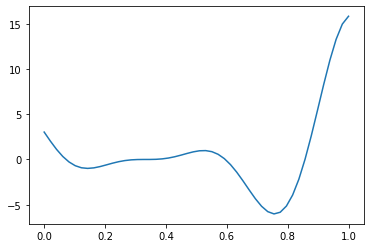

In [4]:
x_range = np.linspace(0, 1)
plt.plot(x_range, objective(x_range));

In [5]:
X = torch.tensor([0.0, 0.1, 0.4, 0.9])
y = objective(X)

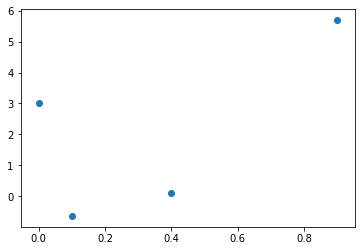

In [6]:
plt.scatter(X, y);

In [7]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [8]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Interval(0.0, 0.001))
model = ExactGPModel(X, y, likelihood)

In [9]:
def fit(model, likelihood, x, y, lr=0.01, n_iter=500, plot_loss=True):

    _pbar_data = {'loss': 0}
    _desc = "Current loss = {loss:.4f}\tOptimizing"
    pbar = tqdm(range(n_iter), desc=_desc.format(**_pbar_data))

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
#         {'params': model.parameters()},  
        {"params": model.covar_module.parameters()},
    ], lr=lr)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    if plot_loss:
        losses = np.empty(n_iter)
    for i in pbar:
        optimizer.zero_grad()
        output = model(x)
        loss = -mll(output, y)
        if plot_loss: losses[i] = loss.item()
        loss.backward()
        if not i % 5:
            _pbar_data['loss'] = loss.detach().cpu().numpy()
            pbar.set_description(_desc.format(**_pbar_data))
        optimizer.step()

    if plot_loss:
        plt.plot(losses)
        
    return model, likelihood, mll

Current loss = 2.9247	Optimizing: 100%|██████████| 1000/1000 [00:03<00:00, 331.59it/s]


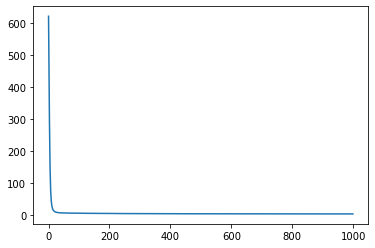

In [10]:
model, likelihood, mll = fit(model, likelihood, X, y, lr=0.1, n_iter=1000)

In [11]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

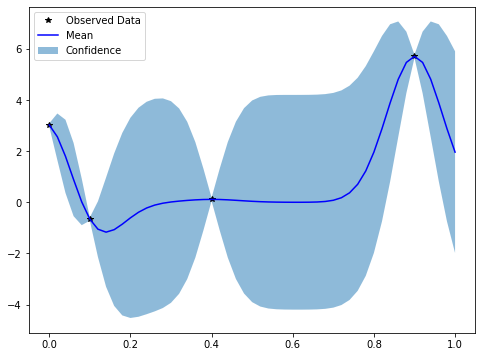

In [12]:
with torch.no_grad():
    # Initialize plot
    f, (ax, ax2) = plt.subplots(2, 1, figsize=(8, 6))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(X.numpy(), y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    
    plt.sca(ax2)
    

In [13]:
model.train_targets.numpy().max()

5.7119417

In [14]:
from scipy.stats import norm

def PI(model, likelihood):
    # calculate the best surrogate score found so far
    best = model.train_targets.numpy().min()
    # calculate mean and stdev via surrogate function
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = torch.linspace(0, 1, 51)
        observed_pred = likelihood(model(test_x))
    mu, std = observed_pred.mean, observed_pred.stddev
    gamma = (mu.numpy() - best) / (std.numpy()+1E-9)
    # calculate the probability of improvement
    probs = 1-norm.cdf(gamma)
    plt.plot(test_x.numpy(), probs)
    return test_x[np.argmax(probs)].item()

$$a _ { E 1 } ( x ) = \sigma ( x ) ( \gamma ( x ) \Phi ( \gamma ( x ) ) + \mathcal { N } ( \gamma ( x ) ; 0,1 ) )$$


In [15]:
def EI(model, likelihood):
    # calculate the best surrogate score found so far
    best = model.train_targets.numpy().min()
    # calculate mean and stdev via surrogate function
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = torch.linspace(0, 1, 51)
        observed_pred = likelihood(model(test_x))
    mu, std = observed_pred.mean.numpy(), observed_pred.stddev.numpy()
    gamma = (mu - best) / (std+1E-9)
    vals = std * (gamma*(1-norm.cdf(gamma)) + norm.pdf(gamma))
    plt.plot(test_x.numpy(), vals)
    opt = test_x[np.argmax(vals)].item()
    plt.scatter(opt, np.max(vals))
    return opt

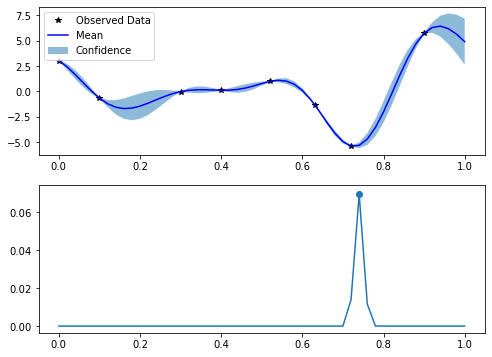

In [32]:
with torch.no_grad():
    # Initialize plot
    f, (ax, ax2) = plt.subplots(2, 1, figsize=(8, 6))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(X.numpy(), y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    
    plt.sca(ax2)
    EI(model, likelihood)

In [17]:
X = torch.tensor([0.0, 0.1, 0.3, 0.4, 0.63, 0.9])
y = objective(X)

In [18]:
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Interval(0.0, 0.001))
model = ExactGPModel(X, y, likelihood)

Current loss = 2.6564	Optimizing: 100%|██████████| 1000/1000 [00:05<00:00, 199.47it/s]


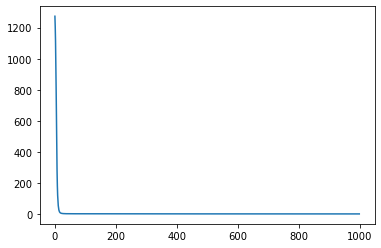

In [19]:
model, likelihood, mll = fit(model, likelihood, X, y, lr=0.1, n_iter=1000)

In [20]:

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

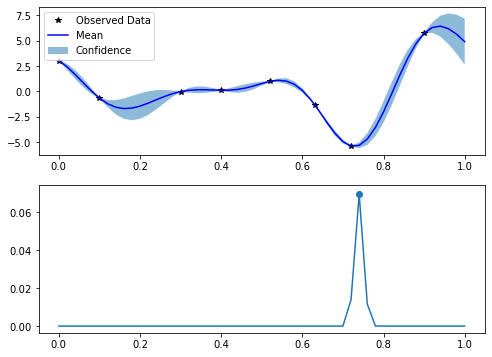

In [33]:
with torch.no_grad():
    # Initialize plot
    f, (ax, ax2) = plt.subplots(2, 1, figsize=(8, 6))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(X.numpy(), y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    
    plt.sca(ax2)
    EI(model, likelihood)

In [23]:
X = torch.tensor([0.0, 0.1, 0.3, 0.4, 0.52, 0.63, 0.72, 0.9])
y = objective(X)

In [24]:
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Interval(0.0, 0.001))
model = ExactGPModel(X, y, likelihood)

Current loss = 4.6089	Optimizing: 100%|██████████| 100/100 [00:00<00:00, 205.33it/s]


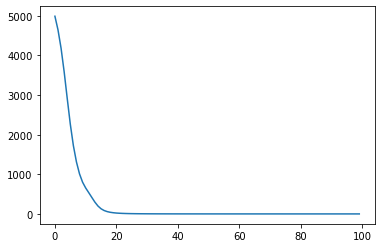

In [25]:
model, likelihood, mll = fit(model, likelihood, X, y, lr=0.1, n_iter=100)

In [26]:

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

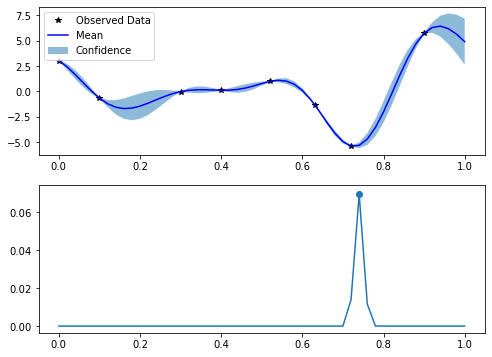

In [31]:
with torch.no_grad():
    # Initialize plot
    f, (ax, ax2) = plt.subplots(2, 1, figsize=(8, 6))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(X.numpy(), y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    
    plt.sca(ax2)
    EI(model, likelihood)

In [ ]:
def update_posterior(x_new):
    y = objective(x_new) # evaluate f at new point.
    X = torch.cat([model.train_inputs[0], 
                   torch.tensor(np.atleast_2d(x_new), dtype=torch.float)])
    y = torch.cat([model.train_targets, 
                   torch.tensor(np.atleast_1d(y), dtype=torch.float)])
    model.set_train_data(X, y)
    # optimize the GP hyperparameters using Adam with lr=0.001
    optimizer = torch.optim.Adam(gpmodel.parameters(), lr=0.001)
    gp.util.train(gpmodel, optimizer)

In [ ]:
def objective(x, noise=0.1):
    noise = np.random.normal(loc=0, scale=noise)
    return (x**2 * np.sin(5 * np.pi * x)**6.0) + noise

In [ ]:
# grid-based sample of the domain [0,1]
X = np.arange(0, 1, 0.01)

In [ ]:
# sample the domain without noise
y = [objective(x, 0) for x in X]

In [ ]:
# sample the domain with noise
ynoise = [objective(x) for x in X]

In [ ]:
ix = np.argmax(y)
print('Optima: x=%.3f, y=%.3f' % (X[ix], y[ix]))

## Bayesian Optimization using pyGPGO

pyGPGO is one of several general-purpose Python libraries for conducting Bayesian optimization. This is a short demonstration of how it can be used.

We will use **Franke's function** as an optimization target:

In [ ]:
def f(x, y):
    # Franke's function (https://www.mathworks.com/help/curvefit/franke.html)
    one = 0.75 * np.exp(-(9 * x - 2)**2/4 - (9 * y - 2)**2/4)
    two = 0.75 * np.exp(-(9 * x + 1)**2/49 - (9 * y + 1)/10)
    three = 0.5 * np.exp(-(9 * x - 7)**2/4 - (9*y - 3)**2/4)
    four = 0.25 * np.exp(-(9 * x - 4)**2 - (9*y - 7)**2)
    return one + two + three - four

A simple visualization of the latter:

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x = np.linspace(0, 1, num=1000)
y = np.linspace(0, 1, num=1000)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

### The empirical Bayes approach (marginal log-likelihood)

We use the Matérn $\nu=3/2$ as our covariance function, a Gaussian Process surrogate and the expected improvement acquisition function. Notice we call the `GaussianProcess` class with arguments `optimize=True` and `usegrads=True`, which specifies that we want to optimize the marginal log-likelihood using exact gradients (`usegrads=False` would approximate them).

In [ ]:
from pyGPGO.covfunc import matern32
from pyGPGO.acquisition import Acquisition
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.GPGO import GPGO

cov = matern32()
gp = GaussianProcess(cov, optimize=True, usegrads=True)
acq = Acquisition(mode='ExpectedImprovement')
param = {'x': ('cont', [0, 1]),
         'y': ('cont', [0, 1])}

We start the opimization process as usual and get our results back:

In [ ]:
np.random.seed(20)
gpgo = GPGO(gp, acq, f, param)
gpgo.run(max_iter=10)

In [ ]:
gpgo.getResult()

### The fully-Bayesian approach

Instead of optimizing the marginal log-likelihood, a fully Bayesian implementation takes into account the uncertainty in the parameters in the optimization procedure by assigning priors and estimating them. The process is identical, except that we change our `GaussianProcess` class by another that implements MCMC sampling (via `pyMC3`). 

We use slice sampling in this example for 300 iterations using a burnin of 100 samples. 

In [ ]:
from pyGPGO.surrogates.GaussianProcessMCMC import GaussianProcessMCMC
import pymc3 as pm

gp = GaussianProcessMCMC(cov, niter=300, burnin=100, step=pm.Slice)
acq = Acquisition(mode='IntegratedExpectedImprovement')

The procedure now is exactly the same as before:

In [ ]:
np.random.seed(42)
gpgo = GPGO(gp, acq, f, param)
gpgo.run(max_iter=10)

We can check the posterior distribution of the hyperparameters $\theta$:

In [ ]:
gpgo.GP.posteriorPlot()

We can then query the estimated location of the optimum.

In [ ]:
gpgo.getResult()

## Hyperparameter Optimization

In this tutorial, we will learn the basics of the Bayesian optimization (BO) framework through a step-by-step example in the context of optimizing the hyperparameters of a binary classifier. But first of all, where is Bayesian optimization useful?

There are a lot of case scenarios, one would typically use the BO framework in situations like:

* The objective function has no closed-form
* No gradient information is available
* In presence of noise

The BO framework uses a surrogate model to approximate the objective function and chooses to optimize it instead according to a chosen criteria. 


Let's start by creating some synthetic data that we will use later for classification.

In [ ]:
from sklearn.datasets import make_moons

np.random.seed(20)
X, y = make_moons(n_samples = 200, noise = 0.1) # Data and target

Before going any further, let's visualize it!

In [ ]:
from matplotlib.colors import ListedColormap

cm_bright = ListedColormap(['#fc4349', '#6dbcdb'])
    
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c = y, cmap = cm_bright)
plt.show()

Let's say that we want to use a Support Vector Machine (SVM) with the radial basis function kernel classifier on this data, which has two usual parameters to optimize, $C$ and $\gamma$. We need to first define a target function that takes these two hyperparameters as input and spits out an error (e.g, using some form of cross validation). Define also a dictionary, specifying parameters and input spaces for each.

In [ ]:
# from sklearn.svm import SVC
# from sklearn.model_selection import cross_val_score

# def evaluateModel(C, gamma):
#     clf = SVC(C=10**C, gamma=10**gamma)
#     return np.average(cross_val_score(clf, X, y))

# params = {'C':      ('cont', (-4, 5)),
#           'gamma':  ('cont', (-4, 5))
#          }

In [ ]:
from torch import nn

def evaluate_model(hidden_size_1, hidden_size_2):

    hidden_size_1 = int(hidden_size_1)
    hidden_size_2 = int(hidden_size_2)
    
    # Build a feed-forward network
    model = nn.Sequential(nn.Linear(2, hidden_size_1),
                          nn.ReLU(),
                          nn.Linear(hidden_size_1, hidden_size_2),
                          nn.ReLU(),
                          nn.Linear(hidden_size_2, 1),
                          nn.Sigmoid())
    
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    for t in range(1000):
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return loss.item()

In [ ]:
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

In [ ]:
evaluate_model(64, 1e-4)

In [ ]:
params = {'hidden_size_1':      ('int', [4, 64]),
          'hidden_size_2':  ('int', [4, 64])
         }

In [ ]:
from pyGPGO.covfunc import squaredExponential
sexp = squaredExponential()
gp = GaussianProcess(sexp)

We specify now an _acquisition function_, that will determine the behaviour of the BO procedure when selecting a new point. For instance, it is very common to use the Expected Improvement (EI) acquisition, that will both take into account the probability of improvement of a point and its magnitude:

In [ ]:
acq = Acquisition(mode = 'ExpectedImprovement')

We're almost done! Finally call the `GPGO` class and put everything together. We'll run the procedure for 20 epochs.

In [ ]:
gpgo = GPGO(gp, acq, evaluate_model, params)
gpgo.run(max_iter = 20)

Finally retrieve your result!

In [ ]:
gpgo.getResult()

---
# References

Rasmussen, C. E., & Williams, C. K. I. (2004). Gaussian processes for machine learning. International journal of neural systems (Vol. 14). http://doi.org/10.1142/S0129065704001899

Snoek, J., Larochelle, H., & Adams, R. P. (2012). Practical Bayesian Optimization of Machine Learning Algorithms. Adv. Neural Inf. Process. Syst. 25, 1–9. http://doi.org/2012arXiv1206.2944S

Jiménez J., Ginebra, J. (2017). Bayesian optimization in machine-learning. http://hdl.handle.net/2117/105999


